### The first model two different ways

I want to try doing the first model in 2 ways:

1. Exactly the way the tutorial did it (one-hot encode targets; use sklean.multilabel to drive 104 binary classifiers across this input).
2. Use logistic regression in a multilabel fashion directly on the input (unencoded).  It will use 9 different classifiers (one for each target).

For both I want to do the following reporting:

1. accuracy score
2. classification report
3. confusion matrix
4. log loss (using sklearn.metrics.log_loss) and the drivendata version.  For sklearn's log_loss, I need to chop up the probability output into 9 chunks and average.  Interesting to see if both arrive at the same value.

### Why is this worth doing?

1. I don't understand why the test scores (computed using the "official" metric) of the "better" models do not track the scored submissions.  It could be that the holdout set is from a different distribution.  Another explanation is that the "official" metric does not compute log_loss correctly.


2. Log_loss doesn't tell me much about what the model gets right or wrong or why.  Standard metrics can be helpful for that.


3. Is one-vs-103 different from (9 * one-vs-num_labels for each target)?  I'm not sure of the answer.  It would seem that when predicting probabilities for labels, the sum of probabilities for each sample ought be one (within one target) and I doubt that 1-vs-103 will do that.


4. It's a simple matter of programming.

### Results Summary

__OneVsRest(LogisticRegression()) on one-hot encoded multi-target nulti-label doesn't predict labels or probabilities the way 
*$NumberOfTargets * MultiLabelClassifier$* does.   We need to do post-processing on the output of OneVsRest.__

__For details, see explanation at the beginning of Flat_to_labels.ipynb.__

#### Imports/setup

In [1]:
### in case I change anything under the covers, make it show up here.
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

# pipeline stuff
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

# stuff in .python directory

### split ensuring train/test both have all labels
from python.multilabel import multilabel_train_test_split
### drivendata metric
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES

In [2]:
def plot_cm(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(np.arange(cm.shape[0])); 
    ax.yaxis.set_ticklabels(np.arange(cm.shape[0]));

#### Load the data

In [3]:
# Get data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [4]:
# take a look
df.head(3)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.81,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.86,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.13,Instruction - Regular,General Purpose School,NaN


####  Encode the labels as categorical variables

In [5]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them in the first approach
LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']

### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


#### Capture all the labels for each output

In [6]:
target_labels = {t : np.unique(df[[t]]) for t in LABELS}

In [7]:
target_labels

{'Function': array(['Aides Compensation', 'Career & Academic Counseling',
        'Communications', 'Curriculum Development',
        'Data Processing & Information Services',
        'Development & Fundraising', 'Enrichment',
        'Extended Time & Tutoring', 'Facilities & Maintenance',
        'Facilities Planning',
        'Finance, Budget, Purchasing & Distribution', 'Food Services',
        'Governance', 'Human Resources',
        'Instructional Materials & Supplies', 'Insurance', 'Legal',
        'Library & Media', 'NO_LABEL', 'Other Compensation',
        'Other Non-Compensation', 'Parent & Community Relations',
        'Physical Health & Services', 'Professional Development',
        'Recruitment', 'Research & Accountability',
        'School Administration', 'School Supervision', 'Security & Safety',
        'Social & Emotional',
        'Special Population Program Management & Support',
        'Student Assignment', 'Student Transportation',
        'Substitute Compensation

# The approach from the tutorial

======================================================================================

#### Setting up a train-test split  for modeling

In [8]:
NUMERIC_COLUMNS = ['FTE', 'Total']

#### multilabel_train_test_split makes sure that all labels appear in both train and test sets.

In [9]:
# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Show the shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(320222, 2) (80055, 2) (320222, 104) (80055, 104)


#### save these indices so I can use them later in the second approach (i.e. I'll use them to get the same data in the splits)

In [10]:
# I can use these indices if I need them so as not to have to mess with multi_label_train_test_split.
(X_train.index == y_train.index).all(), (X_test.index == y_test.index).all()

(True, True)

In [11]:
df[NUMERIC_COLUMNS].shape

(400277, 2)

#### Start with a simple model

The first model ignores everything but the two numeric columns to get started and check for correct format (104 columns of predictions).  

Create a multiclass classifier clf by placing LogisticRegression() inside OneVsRestClassifier()[sic].

Then fit it to the features (the two numeric columns) and the targets (one-hot encoded).

In [12]:
# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)
# Instantiate the classifier: clf
mod0 = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

start = timer()
# Fit the classifier to the training data
mod0.fit(X_train, y_train)
end = timer()
print('fit time: {} seconds'.format(end - start))

fit time: 144.0290496170407 seconds


#### Save the predictions 

In [13]:
_train_idx, _test_idx = X_train.index, X_test.index

In [14]:
# Predict so that we can use sklearn metrics - they compare y and yhat
mod0_train_yhat = mod0.predict(X_train)
mod0_test_yhat = mod0.predict(X_test)

In [15]:
# check shapes of yhats
mod0_train_yhat.shape, mod0_test_yhat.shape

((320222, 104), (80055, 104))

#### Not very accurate but correct format.

In [16]:
print('train accuracy: {:.8f}'.format(accuracy_score( y_train, mod0_train_yhat)))
print('test accuracy: {:.8f}'.format(accuracy_score(y_test, mod0_test_yhat)))

train accuracy: 0.00001249
test accuracy: 0.00000000


### Check classification report

In [17]:
print(classification_report(y_test, mod0_test_yhat))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3981
          1       0.00      0.00      0.00       567
          2       0.00      0.00      0.00        63
          3       0.00      0.00      0.00      1547
          4       0.00      0.00      0.00       599
          5       0.00      0.00      0.00        18
          6       0.00      0.00      0.00      2093
          7       0.00      0.00      0.00      1688
          8       0.00      0.00      0.00      4029
          9       0.00      0.00      0.00         8
         10       0.00      0.00      0.00       437
         11       0.00      0.00      0.00      2900
         12       0.00      0.00      0.00       150
         13       0.00      0.00      0.00       258
         14       0.00      0.00      0.00      3916
         15       0.00      0.00      0.00        20
         16       0.00      0.00      0.00        22
         17       0.00      0.00      0.00   

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### The code below fails, complaining about input format but what's more it messes something up in the guts of numpy pretty printer and printing arrays starts to fail, causing major difficulties.  Beware!
```
np.set_printoptions(threshold='nan')
print(confusion_matrix(y_test, mod0_yhat_test))
np.set_printoptions(threshold=1000)
```

##### To do: need a better way to print a big confusion matrix

### Now get log_loss

For that we need to predict probabilities...

In [18]:
### Predict train and test probas
mod0_train_probas = mod0.predict_proba(X_train)
mod0_test_probas = mod0.predict_proba(X_test)

##### Save the predictions and y values for train and test.

In [19]:
# predictions and values from train and test sets.  All are flattened  (n_samples, 104)
np.savez('./model_out/mod0', 
         m0_train_probas = mod0_train_probas,
         m0_train_yhat   = mod0_train_yhat,
         m0_y_train      = y_train.values,
         m0_test_probas  = mod0_test_probas,
         m0_test_yhat    = mod0_test_yhat,
         m0_y_test       = y_test.values)

##### Check that it worked.

In [20]:
thing = np.load('./model_out/mod0.npz')

In [21]:
thing.keys()

['m0_train_probas',
 'm0_train_yhat',
 'm0_y_train',
 'm0_test_probas',
 'm0_test_yhat',
 'm0_y_test']

##### Indices of the targets after one-hot encoding

In [22]:
BOX_PLOTS_COLUMN_INDICES = [slice(0, 37),
                            slice(37, 48),
                            slice(48, 51),
                            slice(51, 76),
                            slice(76, 79),
                            slice(79, 82),
                            slice(82, 87),
                            slice(87, 96),
                            slice(96, 104)]

In [23]:
# to save typing
BPCI = BOX_PLOTS_COLUMN_INDICES

In [24]:
### Note the order: opposite of sklearn metrics
### Note on inputs: needs nd.arrays for input, if df, use df.values
print('Test set mmll    :  {:.4f}'.format(multi_multi_log_loss(mod0_test_probas, y_test.values, BPCI)))
print('Training set mmll:  {:.4f}'.format(multi_multi_log_loss(mod0_train_probas, y_train.values, BPCI)))

Test set mmll    :  1.3557
Training set mmll:  1.3535


#### So far so good.  This is the same as the results I had before.

__================ End of Model 0, first approach ==================__

### Now do it another way...

In this scheme, fit a multilabel classifier to each target separately.

##### I want to classify each target separately.  It would make more sense to call the targets "TARGETS" rather than "LABELS"

In [25]:
LABELS

['Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Use']

In [26]:
# Create the input DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# This was the first way
# Get labels and convert to dummy variables: label_dummies
# label_dummies = pd.get_dummies(df[LABELS])

### Instead of that, make a df with a column for each target
targets = df[LABELS]

In [27]:
### check the target columns
targets.head()

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use
134338,Teacher Compensation,NO_LABEL,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,NO_LABEL,Instruction
206341,NO_LABEL,NO_LABEL,Non-Operating,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL
326408,Teacher Compensation,Base Salary/Compensation,PreK-12 Operating,Teacher,Non PreK,School,School Reported,Unspecified,Instruction
364634,Substitute Compensation,Benefits,PreK-12 Operating,Substitute,NO_LABEL,School,School Reported,Unspecified,Instruction
47683,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,Unspecified,Instruction


#### Let's start by doing only one target

In [28]:
# save for possible later use
originals = X_train, X_test, y_train, y_test

####  I'd like to scale first, but I didn't before so it's not fair to do it now.  It's worth checking to see if it makes a difference in the output.

[[ Do it 9 x one-vs-rest style but scale input first (using pipeline).  Can do it because I'm only using numerical features.  By the way, it fits 10 times faster with scaled features.  ]]

In [29]:
X_train, X_test, y_train, y_test = originals

# Instantiate the classifier: clf

### Don't scale 
mod0_Function = Pipeline([### ('scale', StandardScaler()),
                          ('logreg', LogisticRegression())])

start = timer()
# Fit the classifier to the training data
### X_train is okay - it's just the numeric data;
### y_train needs to be just the Function column out of target.
mod0_Function.fit(X_train, targets.loc[X_train.index, 'Function'])

end = timer()
print('fit time: {} seconds'.format(end - start))

fit time: 216.33792663528612 seconds


#### Gather all the prediction outputs into a dictionary

In [30]:
m0_Function_out = {'yhat_train'       : mod0_Function.predict(X_train),
                   'yhat_proba_train' : mod0_Function.predict_proba(X_train),
                   'yhat_test'        : mod0_Function.predict(X_test),
                   'yhat_proba_test'  : mod0_Function.predict_proba(X_test) }

### Try scaling and compare results to unscaled version.

In [31]:
# Instantiate the classifier: clf

### this time scale
mod0s_Function = Pipeline([('scale', StandardScaler()),
                           ('logreg', LogisticRegression())])

start = timer()
# Fit the classifier to the training data
### X_train is okay - it's just the numeric data; y_train needs to be just the Function column out of target
mod0s_Function.fit(X_train, targets.loc[X_train.index, 'Function'])

end = timer()
print('fit time: {} seconds'.format(end - start))

fit time: 24.85362495200002 seconds


In [32]:
# predict and save outputs
m0s_Function_out = {'yhat_train'       : mod0s_Function.predict(X_train),
                   'yhat_proba_train' : mod0s_Function.predict_proba(X_train),
                   'yhat_test'        : mod0s_Function.predict(X_test),
                   'yhat_proba_test'  : mod0s_Function.predict_proba(X_test) }

In [33]:
# check test prediction output
m0s_Function_out['yhat_test'][:5]

array(['NO_LABEL', 'NO_LABEL', 'NO_LABEL', 'NO_LABEL',
       'Substitute Compensation'], dtype=object)

#### Comparing predictions

Okay, scaling makes a difference to the output so to compare apples and apples, we can't first scale in this model before checking the difference between one-vs-rest on flattened labels and one-vs-rest internal to a column.

In [34]:
### what percentage of the unscaled/scaled are the same?
(m0_Function_out['yhat_train'] == m0s_Function_out['yhat_train']).sum()/len(m0_Function_out['yhat_train'])

0.9740024108274884

In [35]:
(m0_Function_out['yhat_test'] == m0s_Function_out['yhat_test']).sum()/len(m0_Function_out['yhat_test'])

0.975117106988945

##### Compare probability outputs

These are floats, so compute average absolute difference.

In [36]:
# somewhat different on training set
np.absolute((m0_Function_out['yhat_proba_train'] - m0s_Function_out['yhat_proba_train'])).sum()/len(m0_Function_out['yhat_proba_train'])

0.12263367959215235

In [37]:
# very close on test set
np.absolute((m0_Function_out['yhat_proba_test'] - m0s_Function_out['yhat_proba_test']).sum())/len(m0_Function_out['yhat_proba_test'])

1.2507864403264413e-18

#### Quick experiment:  are the row sums of the probabilty predictions = 1?  Yes, they are.  That's what the other scheme does *not* do.

In [74]:
m0_Function_out['yhat_proba_test'].shape

(80055, 37)

In [79]:
the_row_sums = np.sum(m0_Function_out['yhat_proba_test'], axis=1, keepdims=True)

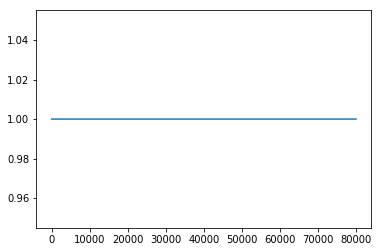

In [80]:
plt.plot(the_row_sums);

### Now expand this approach to fit all 9 targets (without scaling for comparison to mod0).  When that's done, I can compare the metrics between the two approaches.

#####  in pseudo-code
```
for target in targets
    make and name a clf
    fit clf on X_test and target column   
    make predictions for test and train and save
```

In [38]:
### what are the targets??
LABELS

['Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Use']

In [39]:
### Call each classifier m0ml[<target name>]

# make the clfs and stash
_clfs = {}
for t in LABELS:
    _clfs[t] = LogisticRegression()

In [40]:
# now fit them
start_all = timer()
for t in LABELS:  
    start = timer()
    print('Fitting target: {}'.format(t))
    # fit a model
    fm = _clfs[t].fit(X_train, targets.loc[X_train.index, t])

    stop = timer()
    print('fit time for target "{}": {:.1f} seconds'.format(t, stop - start))
    # print model accuracy
    print('Test set accuracy for {}: {:.4f}'.format(t, fm.score(X_test, targets.loc[X_test.index, t])))
    
stop_all = timer()    
print('\nDone.  Total elapsed time: {:.1f}'.format(stop_all - start_all))

Fitting target: Function
fit time for target "Function": 218.3 seconds
Test set accuracy for Function: 0.2760
Fitting target: Object_Type
fit time for target "Object_Type": 31.2 seconds
Test set accuracy for Object_Type: 0.4253
Fitting target: Operating_Status
fit time for target "Operating_Status": 7.6 seconds
Test set accuracy for Operating_Status: 0.8588
Fitting target: Position_Type
fit time for target "Position_Type": 112.9 seconds
Test set accuracy for Position_Type: 0.3729
Fitting target: Pre_K
fit time for target "Pre_K": 4.5 seconds
Test set accuracy for Pre_K: 0.7663
Fitting target: Reporting
fit time for target "Reporting": 5.0 seconds
Test set accuracy for Reporting: 0.6410
Fitting target: Sharing
fit time for target "Sharing": 9.3 seconds
Test set accuracy for Sharing: 0.6337
Fitting target: Student_Type
fit time for target "Student_Type": 27.3 seconds
Test set accuracy for Student_Type: 0.5571
Fitting target: Use
fit time for target "Use": 20.2 seconds
Test set accuracy f

#### Now predict on train, test  and get probabilities.

In [41]:
### make a dictionary to put the predictions and ys (for use with metrics)
m0ml_outs = {}
for t in LABELS:
    mod = _clfs[t]
    # save training set outputs for this target
    m0ml_outs[t + '_train_yhat'] = mod.predict(X_train)
    m0ml_outs[t + '_train_probas'] = mod.predict_proba(X_train)
    m0ml_outs[t + '_train_y'] = targets.loc[X_train.index, t]
    # save test set outputs for this target
    m0ml_outs[t + '_test_yhat'] = mod.predict(X_test)
    m0ml_outs[t + '_test_probas'] = mod.predict_proba(X_test) 
    m0ml_outs[t + '_test_y'] = targets.loc[X_test.index, t]

In [42]:
# take a look
m0ml_outs

{'Function_train_yhat': array(['Teacher Compensation', 'Teacher Compensation', 'NO_LABEL', ...,
        'Substitute Compensation', 'NO_LABEL', 'NO_LABEL'], dtype=object),
 'Function_train_probas': array([[0.07261103, 0.0108835 , 0.00080785, ..., 0.20931259, 0.0060043 ,
         0.00537075],
        [0.07454707, 0.01118834, 0.00083044, ..., 0.21528051, 0.00616998,
         0.00552494],
        [0.03587419, 0.00657149, 0.00081801, ..., 0.18540589, 0.00112401,
         0.00616536],
        ...,
        [0.06345908, 0.00945997, 0.0007027 , ..., 0.18163636, 0.00522194,
         0.00465768],
        [0.03612179, 0.0066201 , 0.00082405, ..., 0.18681166, 0.00113216,
         0.0062124 ],
        [0.0358737 , 0.00657139, 0.000818  , ..., 0.18540311, 0.00112399,
         0.00616527]]),
 'Function_train_y': 134338                               Teacher Compensation
 326408                               Teacher Compensation
 47683                             Substitute Compensation
 229958         

In [43]:
# train and test and train_proba and test_proba, 4 outputs + 2 ys per model, 9 models.
len(list(m0ml_outs.keys()))

54

#### Save m0ml outputs

In [44]:
for (name, array) in m0ml_outs.items():
    print(name, array.shape)

Function_train_yhat (320222,)
Function_train_probas (320222, 37)
Function_train_y (320222,)
Function_test_yhat (80055,)
Function_test_probas (80055, 37)
Function_test_y (80055,)
Object_Type_train_yhat (320222,)
Object_Type_train_probas (320222, 11)
Object_Type_train_y (320222,)
Object_Type_test_yhat (80055,)
Object_Type_test_probas (80055, 11)
Object_Type_test_y (80055,)
Operating_Status_train_yhat (320222,)
Operating_Status_train_probas (320222, 3)
Operating_Status_train_y (320222,)
Operating_Status_test_yhat (80055,)
Operating_Status_test_probas (80055, 3)
Operating_Status_test_y (80055,)
Position_Type_train_yhat (320222,)
Position_Type_train_probas (320222, 25)
Position_Type_train_y (320222,)
Position_Type_test_yhat (80055,)
Position_Type_test_probas (80055, 25)
Position_Type_test_y (80055,)
Pre_K_train_yhat (320222,)
Pre_K_train_probas (320222, 3)
Pre_K_train_y (320222,)
Pre_K_test_yhat (80055,)
Pre_K_test_probas (80055, 3)
Pre_K_test_y (80055,)
Reporting_train_yhat (320222,)
Repor

In [45]:
# predictions and values from train and test sets.  Predictions are single (string) labels; probas are 
# num_labels columns (per target); ys are single (string label).
for (name, arr) in m0ml_outs.items():
    # print(name, arr.shape)
    np.save('./model_out/m0ml_' + name, arr)

__============================= Look at metrics =================================__

#### now look at accuracy and log_loss

In [46]:
### this is for everything but log_loss
### no, not true!
### sklearn.metrics.log_loss will work but I have to pull out the probas not the yhats
def show_metric(train_y, train_pred, test_y, test_pred, metric):
    print(metric.__name__ + ' on target "{}"'.format(t))
    print('train: {:.4f}'.format(metric(train_y, train_pred)))
    print(('test : {:.4f}'.format(metric(test_y, test_pred))))

In [47]:
for t in LABELS:
    (train_y, train_pred, test_y, test_pred) = (targets.loc[X_train.index, t], m0ml_outs[t + '_train_yhat'],
                                                targets.loc[X_test.index, t],  m0ml_outs[t + '_test_yhat'] ) 
                                                
    show_metric(train_y, train_pred, test_y, test_pred, accuracy_score)

accuracy_score on target "Function"
train: 0.2775
test : 0.2760
accuracy_score on target "Object_Type"
train: 0.4259
test : 0.4253
accuracy_score on target "Operating_Status"
train: 0.8583
test : 0.8588
accuracy_score on target "Position_Type"
train: 0.3746
test : 0.3729
accuracy_score on target "Pre_K"
train: 0.7653
test : 0.7663
accuracy_score on target "Reporting"
train: 0.6433
test : 0.6410
accuracy_score on target "Sharing"
train: 0.6363
test : 0.6337
accuracy_score on target "Student_Type"
train: 0.5575
test : 0.5571
accuracy_score on target "Use"
train: 0.5090
test : 0.5082


In [48]:
for t in LABELS:
    (train_y, train_pred, test_y, test_pred) = (targets.loc[X_train.index, t], m0ml_outs[t + '_train_probas'],
                                                targets.loc[X_test.index, t],  m0ml_outs[t + '_test_probas'] ) 
                                                
    show_metric(train_y, train_pred, test_y, test_pred, log_loss)

log_loss on target "Function"
train: 2.5967
test : 2.6005
log_loss on target "Object_Type"
train: 1.7788
test : 1.7793
log_loss on target "Operating_Status"
train: 0.4398
test : 0.4372
log_loss on target "Position_Type"
train: 2.0705
test : 2.0765
log_loss on target "Pre_K"
train: 0.6172
test : 0.6171
log_loss on target "Reporting"
train: 0.8631
test : 0.8652
log_loss on target "Sharing"
train: 1.1064
test : 1.1127
log_loss on target "Student_Type"
train: 1.2357
test : 1.2390
log_loss on target "Use"
train: 1.4590
test : 1.4599


In [49]:
__test_losses = [log_loss(targets.loc[X_test.index, t],  
                          m0ml_outs[t + '_test_probas']) for t in LABELS ]; __test_losses

[2.600496837659356,
 1.7792535140892818,
 0.43724945818104877,
 2.076473813409829,
 0.6170593306706906,
 0.8652013740752408,
 1.112704011209644,
 1.2390220254167965,
 1.4599081710444692]

In [50]:
average_test_loss = np.mean(__test_losses)

In [51]:
print(average_test_loss)

1.3541520595284842


####  That result tracks the result  in the first approach.  In addition, I want to see if the predictions made by the 2 models differ.  

If we build the corresponding shape from the outputs of the 9 multilabel classifiers the two models can be compared directly.  Additionally, the DrivenData mmll metric can be run on the later model's output.


In [52]:
# list of probabilities output for test set
__m0ml_test_probas = [m0ml_outs[t + '_test_probas'] for t in LABELS]

# Put together the test probas from each clf
m0ml_test_probas = np.concatenate(__m0ml_test_probas, axis=1); m0ml_test_probas.shape

(80055, 104)

#### Now run the Drivendata "official" log loss metric on both probability outputs.

In [53]:
# the result from the first model
multi_multi_log_loss(mod0_test_probas, y_test.values, BPCI)

1.3557282270290794

##### Drivendata metric provides exactly the same output as my approach to this metric (average for all classifiers log loss as computed with sklearn.metric.log_loss).

In [54]:
# the result from the second model
multi_multi_log_loss(m0ml_test_probas, y_test.values, BPCI)

1.354152059528484

#### Now check the average absolute difference between the 2 outputs


In [55]:
np.mean(np.absolute(mod0_test_probas - m0ml_test_probas))

0.008822192114205435

#### They are close on average.  So why does the first model have accuracy score of 0.00.   Accuracy is the proportion of correct predictions.  Some of the predictions from the second approach are correct.  Is it really true that the first approach gets nothing right??  If so, how does it manage to have low log_loss?

#### Maybe it's the application of accuracy_score that's incorrect.

If I take the sections of the the initial model's prediction output and corresponding y-values (also one-hot encoded) that would be the same context for the metric as I used in the second approach.  

That may give me some insight into this issue.

I may (probably) need to reverse the one-hot encoding before that will work.

#### Look at accuracy of first model.  Compare to 2nd model.  

###### variables


* first model test predictions     mod0_yhat_test
* 2nd   model test predictions     are stashed away in a dictionary moml_outs

* first model test probabilities mod0_yhat_proba_test
* 2nd   model test probabilities m0ml_test_probas  [[these were picked out of the dictionary and glued together]]


#### What happens if I look at first model's accuracy for just one output?

In [56]:
type(y_test), type(mod0_test_yhat)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [57]:
y_test.values.shape, mod0_test_yhat.shape

((80055, 104), (80055, 104))

In [58]:
# The "Function" output
accuracy_score(y_test.values[:,:37], mod0_test_yhat[:,:37])

0.00024982824308288055

In [59]:
y_test.values.shape

(80055, 104)

#### So there is exactly 1 hot in each 9 targets in each row of y_test

In [60]:
np.sum(y_test.values)/9

80055.0

In [61]:
# how many ones in mod0 prediction
np.sum(mod0_test_yhat)/9

49009.666666666664

##### Build flattened version of predictions of 2nd model

In [62]:
# list of test predictions for the 9 clfs.  9 1d arrays
__m0ml_test_yhats_flat = [m0ml_outs[t + '_test_yhat'] for t in LABELS ]

In [63]:
# now one-hot encode
_m0ml_test_yhats_flat = [label_binarize(m0ml_outs[t + '_test_yhat'], target_labels[t]) for t in LABELS ]

In [64]:
# check the shapes
[x.shape for x in _m0ml_test_yhats_flat]

[(80055, 37),
 (80055, 11),
 (80055, 3),
 (80055, 25),
 (80055, 3),
 (80055, 3),
 (80055, 5),
 (80055, 9),
 (80055, 8)]

In [65]:
# add up the number of columns; should be 104
sum([x.shape[1] for x in _m0ml_test_yhats_flat])

104

In [66]:
# Put together the test predictions from each clf
m0ml_test_yhats_flat = np.concatenate(_m0ml_test_yhats_flat, axis=1); m0ml_test_yhats_flat.shape

(80055, 104)

#### Now we can see how many ones are in the 2nd model's prediction.

In [67]:
# the right number, 1 for each of 9 targets for 80055 rows
np.sum(m0ml_test_yhats_flat)/9

80055.0

#### 2nd approach gets 28% accuracy on 'Function'.  What's the difference?

In [68]:
# is there at least one positive prediction?  yes.
np.max(mod0_test_yhat[:, :37])

1

In [69]:
# how many positive predictions; not very many -- there should be 80k+, one for each row
np.sum(mod0_test_yhat[:,:37]), np.sum(mod0_test_yhat[:, :37])/mod0_test_yhat[:,:37].shape[0]

(592, 0.007394915995253264)

#### If these were normalized (sum of each row within a label should be 1.0), it might fix this.

In [70]:
# column sums for 37 columns
np.sum(mod0_test_yhat[:, :37], axis=0)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   4,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 588,   0,   0,   0])

#### So why not plot both prediction outputs?

The answer is m0ml prediction outputs aren't in the same format as m0 - they're tucked away in a dictionary.  But I can put them together in a similar fashion to what I did for the probability outputs.

Errrrr..., not so fast.  Those predictions are strings (representing classes).  I have to one-hot encode them to get the same format as prediction output from mod0.  label_binarizer can do that.

##### The profile of the first model 
It would be nice to indicate the boundary of each output.

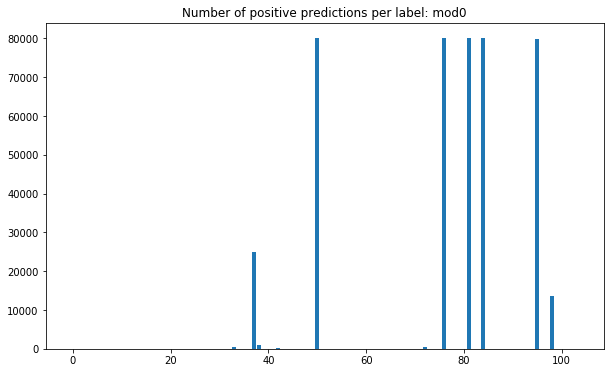

In [71]:
# 104 columns sums for mod0 predictions
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(np.arange(104),(np.sum(mod0_test_yhat[:, :], axis=0)))
plt.title('Number of positive predictions per label: mod0');

##### Plot 2nd model profile

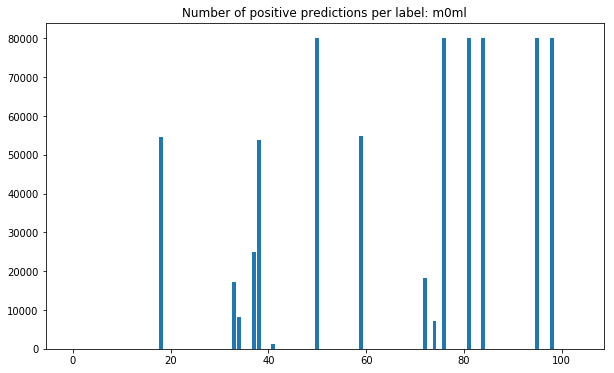

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(np.arange(104),(np.sum(m0ml_test_yhats_flat[:, :], axis=0)))
plt.title('Number of positive predictions per label: m0ml');

#### So you see a profile for each (one-hot encoded) label for each model.  There are similarities and differences.  The 2nd model has many more positive predictions.

Another interesting question: what would we see if we plot the actual data in this framework?

#### The column sums of the actual values

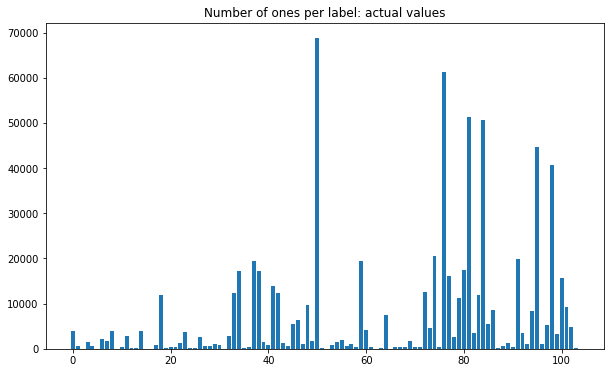

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(np.arange(104),(np.sum(y_test.values, axis=0)))
plt.title('Number of ones per label: actual values');

__===================================================================================__

####  Note:Tried multinomial keyword to logistic regression without success. 

Doesn't seem to fully utilize all processors.  Needs more iterations.  Did not converge at 100, 200 or 400 iterations with 'sag' or 'saga' solvers and scaled input.  Needs scaled numerical features to converge fast (docs say).

Multinomial keyword doesn't seem to work so well.  The default method value for this argument is 'ovr'.  That means 'OneVsRest'.
That works very quickly given scaled input.

Multinomial='multiclass' needs a non-default solver ('sag', 'saga', others).  There are restrictions on what can be used together.  

